# Introduction

This notebook walks through a full implementation of the original Neural Radiance Field architecture, first introduced by Mildenhall et al. in "[NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis.](https://www.matthewtancik.com/nerf)" For a broader overview, read the accompanying Medium article "[It's NeRF From Nothing: Build A Complete NeRF With Pytorch.](https://medium.com/@masonmcgough/its-nerf-from-nothing-build-a-vanilla-nerf-with-pytorch-7846e4c45666)" This notebook assumes that you have read that article and understand the basics of NeRF.

Much of the code comes from or is inspired by the original implementation by GitHub user [bmild](https://github.com/bmild/nerf) as well as PyTorch implementations from GitHub users [yenchenlin](https://github.com/bmild/nerf) and [krrish94](https://github.com/krrish94/nerf-pytorch/). The code has been modified for clarity and consistency.

## Imports

In [2]:
import os
from typing import Optional, Tuple, List, Union, Callable

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from tqdm import trange
import pdb

# For repeatability
seed = 3407
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Inputs

## Data

First we load the data which we will train our NeRF model on. This is the Lego bulldozer commonly seen in the NeRF demonstrations and serves as a sort of "Hello World" for training NeRFs. Covering other datasets is outside the scope of this notebook, but feel free to try others included in the original [NeRF source code](https://github.com/bmild/nerf) or your own datasets.

In [3]:
if not os.path.exists('tiny_nerf_data.npz'):
  !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

This dataset consists of 106 images taken of the synthetic Lego bulldozer along with poses and a common focal length value. Like the original, we reserve the first 100 images for training and a single test image for validation.

Images shape: (106, 100, 100, 3)
Poses shape: (106, 4, 4)
Focal length: 138.88887889922103
Pose
[[ 6.8935126e-01 -5.3373039e-01  4.8982298e-01 -1.9745398e+00]
 [-7.2442728e-01 -5.0788772e-01  4.6610624e-01 -1.8789345e+00]
 [ 1.4901163e-08 -6.7615211e-01 -7.3676193e-01  2.9699826e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


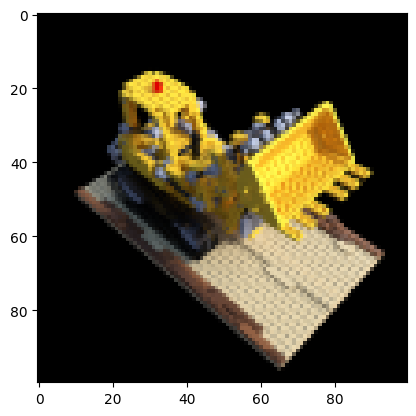

In [4]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses'] # shape [106,4,4] # c2w in OpenGL convention
focal = data['focal']

# --- Convert OpenGL -> OpenCV c2w -------------------------------------
# OpenGL camera axes:  x_right, y_up,     z_back  (camera looks along -Z)
# OpenCV camera axes:  x_right, y_down,   z_forward

S = np.diag([1.0, -1.0, -1.0, 1.0]).astype(np.float32)  # 4x4
poses = poses @ S[None, ...]                          # (N,4,4)

print(f'Images shape: {images.shape}')
print(f'Poses shape: {poses.shape}')
print(f'Focal length: {focal}')

height, width = images.shape[1:3]
near, far = 2., 6.

n_training = 100
testimg_idx = 101
testimg, testpose = images[testimg_idx], poses[testimg_idx]

plt.imshow(testimg)
print('Pose')
print(testpose)

## Origins and Directions

Recall that NeRF processes inputs from a field of positions (x,y,z) and view directions (θ,φ). To gather these input points, we need to apply inverse rendering to the input images. More concretely, we draw projection lines through each pixel and across the 3D space, from which we can draw samples.

To sample points from the 3D space beyond our image, we first start from the initial pose of every camera taken in the photo set. With some vector math, we can convert these 4x4 pose matrices into a 3D coordinate denoting the origin and a 3D vector indicating the direction. The two together describe a vector that indicates where a camera was pointing when the photo was taken.

The code in the cell below illustrates this by drawing arrows that depict the origin and the direction of every frame.

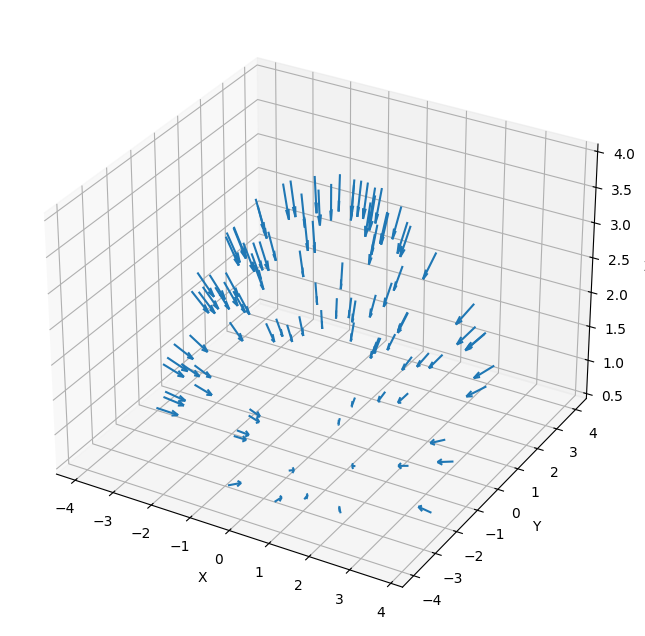

In [5]:
# Camera centers (world)
origins = poses[:, :3, 3]         # (N, 3)

# Camera basis vectors in world
rights  = poses[:, :3, 0]         # +X (right)
ups     = poses[:, :3, 1]         # +Y (down in OpenCV camera frame)
forwards = poses[:, :3, 2]        # +Z (forward/look)

# Choose what to draw (here: only forward/look)
dirs = forwards  # use rights/ups too if you want to visualize axes

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection='3d')

ax.quiver(
    origins[:, 0], origins[:, 1], origins[:, 2],
    dirs[:, 0],    dirs[:, 1],    dirs[:, 2],
    length=0.5, normalize=True
)

ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
plt.show()

With this camera pose, we can now find the projection lines along each pixel of our image. Each line is defined by its origin point (x,y,z) and its direction (in this case a 3D vector). While the origin is the same for every pixel, the direction is slightly different. These lines are slightly deflected off center such that none of these lines are parallel.

![Pinhole camera](https://www.researchgate.net/profile/Willy-Azarcoya-Cabiedes/publication/317498100/figure/fig10/AS:610418494013440@1522546518034/Pin-hole-camera-model-terminology-The-optical-center-pinhole-is-placed-at-the-origin.png)

From [Willy Azarcoya-Cabiedes via ResearchGate](https://www.researchgate.net/figure/Pin-hole-camera-model-terminology-The-optical-center-pinhole-is-placed-at-the-origin_fig10_317498100)

In [6]:
def get_rays(
    height: int,
    width: int,
    focal_length: float,
    c2w: torch.Tensor
) -> Tuple[torch.Tensor, torch.Tensor]:
    r"""
    OpenCV convention (camera-to-world):
      - Camera axes: +X right, +Y down, +Z forward
      - Pinhole:  u = fx * X/Z + cx,  v = fy * Y/Z + cy
      - Here we assume fx = fy = focal_length and cx = W/2, cy = H/2

    Returns:
      rays_o: (H, W, 3) origins in world coords (camera center)
      rays_d: (H, W, 3) directions in world coords (not normalized)
    """
    if isinstance(c2w, np.ndarray):
        c2w = torch.from_numpy(c2w).float()
    c2w = c2w.to(torch.float32)

    device = c2w.device

    # Pixel grids (i = u = column, j = v = row)
    i, j = torch.meshgrid(
        torch.arange(width,  dtype=torch.float32, device=device),
        torch.arange(height, dtype=torch.float32, device=device),
        indexing='ij'
    )
    # Make them (H, W) to match image layout [row, col]
    i, j = i.transpose(-1, -2), j.transpose(-1, -2)

    # YOUR CODE HERE
    # We assume the principal point is at the center of the image plane.
    cx = torch.tensor(width * 0.5, dtype=torch.float32, device=device)
    cy = torch.tensor(height * 0.5, dtype=torch.float32, device=device)
    f = torch.as_tensor(focal_length, dtype=torch.float32, device=device)
    fx = f
    fy = f

    # Camera-frame directions (OpenCV: +Y down, +Z forward)
    # The goal here is to convert pixel coordinates (i, j)
    # from the image plane coordinate system
    # into *normalized camera coordinates where z=1*.
    directions_cam = torch.stack([
        (i - cx) / fx,          # normalized x coordinate
        (j - cy) / fy,          # normalized y coordinate
        torch.ones_like(i)      # z = +1
    ], dim=-1)                  # (H, W, 3) row-vector per pixel

    # END OF YOUR CODE

    # Rotate to world: since each direction is a row vector, use R.T
    R = c2w[:3, :3]            # (3,3)
    t = c2w[:3, 3]             # (3,)
    rays_d = directions_cam @ R.T          # (H, W, 3)

    rays_o = t.view(1, 1, 3).expand_as(rays_d)

    return rays_o, rays_d

In [28]:
testpose

tensor([[ 6.8935e-01, -5.3373e-01,  4.8982e-01, -1.9745e+00],
        [-7.2443e-01, -5.0789e-01,  4.6611e-01, -1.8789e+00],
        [ 1.4901e-08, -6.7615e-01, -7.3676e-01,  2.9700e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0')

In [29]:
focal

138.88887889922103

In [30]:
# Gather as torch tensors
images = torch.from_numpy(data['images'][:n_training]).to(device)
poses = torch.from_numpy(poses).to(device)
focal = torch.from_numpy(data['focal']).to(device)
testimg = torch.from_numpy(data['images'][testimg_idx]).to(device)
testpose = poses[testimg_idx]

# Grab rays from sample image
height, width = images.shape[1:3]
with torch.no_grad():
  ray_origin, ray_direction = get_rays(height, width, focal, testpose)

print('Ray Origin')
print(ray_origin.shape)
print(ray_origin[height // 2, width // 2, :])
print('')

print('Ray Direction')
print(ray_direction.shape)
print(ray_direction[height // 2, width // 2, :])
print('')

TypeError: expected np.ndarray (got Tensor)

# Architecture

## Stratified Sampling

Now that we have these lines, defined as origin and direction vectors, we can begin the process of sampling them. Recall that NeRF takes a coarse-to-fine sampling strategy, starting with the stratified sampling approach.

The stratified sampling approach splits the ray into evenly-spaced bins and randomly samples within each bin. The `perturb` setting determines whether to sample points uniformly from each bin or to simply use the bin center as the point. In most cases, we want to keep `perturb = True` as it will encourage the network to learn over a continuously sampled space. It may be useful to disable for debugging.

In [31]:
def sample_stratified(
  rays_o: torch.Tensor,
  rays_d: torch.Tensor,
  near: float,
  far: float,
  n_samples: int,
  perturb: Optional[bool] = True,
  inverse_depth: bool = False
) -> Tuple[torch.Tensor, torch.Tensor]:
  r"""
  Sample along ray from regularly-spaced bins.
  """

  # Grab samples for space integration along ray
  t_vals = torch.linspace(0., 1., n_samples, device=rays_o.device)
  if not inverse_depth:
    # Sample linearly between `near` and `far`
    z_vals = near * (1.-t_vals) + far * (t_vals)
  else:
    # Sample linearly in inverse depth (disparity)
    z_vals = 1./(1./near * (1.-t_vals) + 1./far * (t_vals))

  # ------------------------------------------------------------------
  # Now we perform *stratified sampling* along each ray.
  #
  # The idea:
  #   We divide the ray segment between near and far into n_samples bins.
  #   For each bin, instead of always taking the midpoint (which would be deterministic),
  #   we randomly sample one point inside the bin.
  #
  #   This adds slight randomness (perturbation) during training,
  #   which improves the robustness and smoothness of the final rendering.
  #
  #   lower and upper represent the boundaries of each sampling bin.
  #   t_rand is a random number (between 0 and 1) for each bin.
  # ------------------------------------------------------------------
  if perturb:

    # Compute the midpoints between consecutive z values
    mids = .5 * (z_vals[1:] + z_vals[:-1])

    # Define the upper and lower boundaries for each bin
    upper = torch.concat([mids, z_vals[-1:]], dim=-1)
    lower = torch.concat([z_vals[:1], mids], dim=-1)

    # Generate random offsets within each bin
    # (one random number per sample)
    t_rand = torch.rand([n_samples], device=z_vals.device)

    # Sample a random point between lower and upper boundaries
    z_vals = lower + (upper - lower) * t_rand

  z_vals = z_vals.expand(list(rays_o.shape[:-1]) + [n_samples])

  # Apply scale from `rays_d` and offset from `rays_o` to samples
  # pts: (width, height, n_samples, 3)
  pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None]
  return pts, z_vals

In [32]:
# Draw stratified samples from example
rays_o = ray_origin.view([-1, 3])
rays_d = ray_direction.view([-1, 3])
n_samples = 8
perturb = True
inverse_depth = False
with torch.no_grad():
  pts, z_vals = sample_stratified(rays_o, rays_d, near, far, n_samples,
                                  perturb=perturb, inverse_depth=inverse_depth)

print('Input Points')
print(pts.shape)
print('')
print('Distances Along Ray')
print(z_vals.shape)

Input Points
torch.Size([10000, 8, 3])

Distances Along Ray
torch.Size([10000, 8])


Now we visualize these sampled points. The unperturbed blue points are the bin "centers." The red points are a sampling of perturbed points. Notice how the red points are slightly offset from the blue points above them, but all are constrained between `near` and `far`.

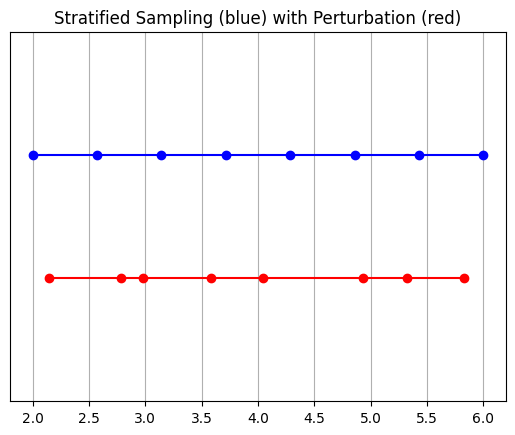

In [33]:
y_vals = torch.zeros_like(z_vals)

_, z_vals_unperturbed = sample_stratified(rays_o, rays_d, near, far, n_samples,
                                  perturb=False, inverse_depth=inverse_depth)
plt.plot(z_vals_unperturbed[0].cpu().numpy(), 1 + y_vals[0].cpu().numpy(), 'b-o')
plt.plot(z_vals[0].cpu().numpy(), y_vals[0].cpu().numpy(), 'r-o')
plt.ylim([-1, 2])
plt.title('Stratified Sampling (blue) with Perturbation (red)')
ax = plt.gca()
ax.axes.yaxis.set_visible(False)
plt.grid(True)

## Positional Encoder

Much like Transformers, NeRFs make use of positional encoders. In this case, it's to map the inputs to a higher frequency space to compensate for the bias that neural networks have for learning lower-frequency functions.

Here we build a simple `torch.nn.Module` of our positional encoder. The same encoder implementation can be applied to both input samples and view directions. However, we choose different parameters for these inputs. We use the default settings from the original.

In [34]:
class PositionalEncoder(nn.Module):
  r"""
  Sine-cosine positional encoder for input points.
  """
  def __init__(
    self,
    d_input: int,
    n_freqs: int,
    log_space: bool = False
  ):
    super().__init__()
    self.d_input = d_input
    self.n_freqs = n_freqs
    self.log_space = log_space
    self.d_output = d_input * (1 + 2 * self.n_freqs)
    self.embed_fns = [lambda x: x]

    # Define frequencies in either linear or log scale
    if self.log_space:
      freq_bands = 2.**torch.linspace(0., self.n_freqs - 1, self.n_freqs)
    else:
      freq_bands = torch.linspace(2.**0., 2.**(self.n_freqs - 1), self.n_freqs)

    # Alternate sin and cos
    for freq in freq_bands:
      self.embed_fns.append(lambda x, freq=freq: torch.sin(x * freq))
      self.embed_fns.append(lambda x, freq=freq: torch.cos(x * freq))

  def forward(
    self,
    x
  ) -> torch.Tensor:
    r"""
    Apply positional encoding to input.
    """
    return torch.concat([fn(x) for fn in self.embed_fns], dim=-1)


In [35]:
# Create encoders for points and view directions
encoder = PositionalEncoder(3, 10)
viewdirs_encoder = PositionalEncoder(3, 4)

# Grab flattened points and view directions
pts_flattened = pts.reshape(-1, 3)
viewdirs = rays_d / torch.norm(rays_d, dim=-1, keepdim=True)
flattened_viewdirs = viewdirs[:, None, ...].expand(pts.shape).reshape((-1, 3))

# Encode inputs
encoded_points = encoder(pts_flattened)
encoded_viewdirs = viewdirs_encoder(flattened_viewdirs)

print('Encoded Points')
print(encoded_points.shape)
print(torch.min(encoded_points), torch.max(encoded_points), torch.mean(encoded_points))
print('')

print(encoded_viewdirs.shape)
print('Encoded Viewdirs')
print(torch.min(encoded_viewdirs), torch.max(encoded_viewdirs), torch.mean(encoded_viewdirs))
print('')

Encoded Points
torch.Size([80000, 63])
tensor(-2.7160, device='cuda:0') tensor(3.4248, device='cuda:0') tensor(0.0271, device='cuda:0')

torch.Size([80000, 27])
Encoded Viewdirs
tensor(-1., device='cuda:0') tensor(1., device='cuda:0') tensor(0.1056, device='cuda:0')



## NeRF Model

Here we define the NeRF model, which consists primarily of a `ModuleList` of `Linear` layers, separated by non-linear activation functions and the occasional residual connection. This model features an optional input for view directions, which will alter the model architecture if provided at instantiation. This implementation is based on Section 3 of the original "NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis" paper and uses the same defaults.

In [36]:
class NeRF(nn.Module):
  r"""
  Neural radiance fields module.
  """
  def __init__(
    self,
    d_input: int = 3,
    n_layers: int = 8,
    d_filter: int = 256,
    skip: Tuple[int] = (4,),
    d_viewdirs: Optional[int] = None
  ):
    super().__init__()
    self.d_input = d_input
    self.skip = skip
    self.act = nn.functional.relu
    self.d_viewdirs = d_viewdirs

    # Create model layers
    self.layers = nn.ModuleList(
      [nn.Linear(self.d_input, d_filter)] +
      [nn.Linear(d_filter + self.d_input, d_filter) if i in skip \
       else nn.Linear(d_filter, d_filter) for i in range(n_layers - 1)]
    )

    # Bottleneck layers
    if self.d_viewdirs is not None:
      # If using viewdirs, split alpha and RGB
      self.alpha_out = nn.Linear(d_filter, 1)
      self.rgb_filters = nn.Linear(d_filter, d_filter)
      self.branch = nn.Linear(d_filter + self.d_viewdirs, d_filter // 2)
      self.output = nn.Linear(d_filter // 2, 3)
    else:
      # If no viewdirs, use simpler output
      self.output = nn.Linear(d_filter, 4)

  def forward(
    self,
    x: torch.Tensor,
    viewdirs: Optional[torch.Tensor] = None
  ) -> torch.Tensor:
    r"""
    Forward pass with optional view direction.
    """

    # Cannot use viewdirs if instantiated with d_viewdirs = None
    if self.d_viewdirs is None and viewdirs is not None:
      raise ValueError('Cannot input x_direction if d_viewdirs was not given.')

    # Apply forward pass up to bottleneck
    x_input = x
    for i, layer in enumerate(self.layers):
      x = self.act(layer(x))
      if i in self.skip:
        x = torch.cat([x, x_input], dim=-1)

    # Apply bottleneck
    if self.d_viewdirs is not None:
      # Split alpha from network output
      alpha = self.alpha_out(x)

      # Pass through bottleneck to get RGB
      feat_rgb = self.rgb_filters(x)

      # Concatenate rgb feature with viewing direction
      x = torch.cat([feat_rgb, viewdirs], dim=-1)
      x = self.act(self.branch(x))
      x = self.output(x)

      # Concatenate alphas to output
      x = torch.cat([x, alpha], dim=-1)
    else:
      # Simple output
      x = self.output(x)
    return x

## Volume Rendering

From the raw NeRF outputs, we still need to convert these into an image. This is where we apply the volume integration described in Equations 1-3 in Section 4 of the paper. Essentially, we take the weighted sum of all samples along the ray of each pixel to get the estimated color value at that pixel. Each RGB sample is weighted by its alpha value. Higher alpha values indicate higher likelihood that the sampled area is opaque, therefore points further along the ray are likelier to be occluded. The cumulative product ensures that those further points are dampened.

In [37]:
def cumprod_exclusive(
  tensor: torch.Tensor
) -> torch.Tensor:
  r"""
  (Courtesy of https://github.com/krrish94/nerf-pytorch)

  Mimick functionality of tf.math.cumprod(..., exclusive=True), as it isn't available in PyTorch.

  Args:
  tensor (torch.Tensor): Tensor whose cumprod (cumulative product, see `torch.cumprod`) along dim=-1
    is to be computed.
  Returns:
  cumprod (torch.Tensor): cumprod of Tensor along dim=-1, mimiciking the functionality of
    tf.math.cumprod(..., exclusive=True) (see `tf.math.cumprod` for details).
  """

  # Compute regular cumprod first (this is equivalent to `tf.math.cumprod(..., exclusive=False)`).
  cumprod = torch.cumprod(tensor, -1)
  # "Roll" the elements along dimension 'dim' by 1 element.
  cumprod = torch.roll(cumprod, 1, -1)
  # Replace the first element by "1" as this is what tf.cumprod(..., exclusive=True) does.
  cumprod[..., 0] = 1.

  return cumprod

def raw2outputs(
  raw: torch.Tensor,
  z_vals: torch.Tensor,
  rays_d: torch.Tensor,
  raw_noise_std: float = 0.0,
  white_bkgd: bool = False
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
  r"""
  Convert the raw NeRF output into RGB and other maps.
  """

  # Difference between consecutive elements of `z_vals`. [n_rays, n_samples]
  dists = z_vals[..., 1:] - z_vals[..., :-1]
  dists = torch.cat([dists, 1e10 * torch.ones_like(dists[..., :1])], dim=-1)

  # Multiply each distance by the norm of its corresponding direction ray
  # to convert to real world distance (accounts for non-unit directions).
  dists = dists * torch.norm(rays_d[..., None, :], dim=-1)

  # Add noise to model's predictions for density. Can be used to
  # regularize network during training (prevents floater artifacts).
  noise = 0.
  if raw_noise_std > 0.:
    noise = torch.randn(raw[..., 3].shape) * raw_noise_std

  # Predict density of each sample along each ray. Higher values imply
  # higher likelihood of being absorbed at this point. [n_rays, n_samples]
  alpha = 1.0 - torch.exp(-nn.functional.relu(raw[..., 3] + noise) * dists)

  # Compute weight for RGB of each sample along each ray. [n_rays, n_samples]
  # The higher the alpha, the lower subsequent weights are driven.
  weights = alpha * cumprod_exclusive(1. - alpha + 1e-10)

  # Compute weighted RGB map.
  rgb = torch.sigmoid(raw[..., :3])  # [n_rays, n_samples, 3]
  rgb_map = torch.sum(weights[..., None] * rgb, dim=-2)  # [n_rays, 3]

  # Estimated depth map is predicted distance.
  depth_map = torch.sum(weights * z_vals, dim=-1)

  # Disparity map is inverse depth.
  disp_map = 1. / torch.max(1e-10 * torch.ones_like(depth_map),
                            depth_map / torch.sum(weights, -1))

  # Sum of weights along each ray. In [0, 1] up to numerical error.
  acc_map = torch.sum(weights, dim=-1)

  # To composite onto a white background, use the accumulated alpha map.
  if white_bkgd:
    rgb_map = rgb_map + (1. - acc_map[..., None])

  return rgb_map, depth_map, acc_map, weights

## Hierarchical Volume Sampling

The 3D space is in fact very sparse with occlusions and so most points don't contribute much to the rendered image. It is therefore more beneficial to oversample regions with a high likelihood of contributing to the integral. Here we apply learned, normalized weights to the first set of samples to create a PDF across the ray, then apply inverse transform sampling to this PDF to gather a second set of samples.

In [38]:
def sample_pdf(
  bins: torch.Tensor,
  weights: torch.Tensor,
  n_samples: int,
  perturb: bool = False
) -> torch.Tensor:
  r"""
  Apply inverse transform sampling to a weighted set of points.
  """

  # Normalize weights to get PDF.
  pdf = (weights + 1e-5) / torch.sum(weights + 1e-5, -1, keepdims=True) # [n_rays, weights.shape[-1]]

  # Convert PDF to CDF.
  cdf = torch.cumsum(pdf, dim=-1) # [n_rays, weights.shape[-1]]
  cdf = torch.concat([torch.zeros_like(cdf[..., :1]), cdf], dim=-1) # [n_rays, weights.shape[-1] + 1]

  # Take sample positions to grab from CDF. Linear when perturb == 0.
  if not perturb:
    u = torch.linspace(0., 1., n_samples, device=cdf.device)
    u = u.expand(list(cdf.shape[:-1]) + [n_samples]) # [n_rays, n_samples]
  else:
    u = torch.rand(list(cdf.shape[:-1]) + [n_samples], device=cdf.device) # [n_rays, n_samples]

  # Find indices along CDF where values in u would be placed.
  u = u.contiguous() # Returns contiguous tensor with same values.
  inds = torch.searchsorted(cdf, u, right=True) # [n_rays, n_samples]

  # Clamp indices that are out of bounds.
  below = torch.clamp(inds - 1, min=0)
  above = torch.clamp(inds, max=cdf.shape[-1] - 1)
  inds_g = torch.stack([below, above], dim=-1) # [n_rays, n_samples, 2]

  # Sample from cdf and the corresponding bin centers.
  matched_shape = list(inds_g.shape[:-1]) + [cdf.shape[-1]]
  cdf_g = torch.gather(cdf.unsqueeze(-2).expand(matched_shape), dim=-1,
                       index=inds_g)
  bins_g = torch.gather(bins.unsqueeze(-2).expand(matched_shape), dim=-1,
                        index=inds_g)

  # Convert samples to ray length.
  denom = (cdf_g[..., 1] - cdf_g[..., 0])
  denom = torch.where(denom < 1e-5, torch.ones_like(denom), denom)
  t = (u - cdf_g[..., 0]) / denom
  samples = bins_g[..., 0] + t * (bins_g[..., 1] - bins_g[..., 0])

  return samples # [n_rays, n_samples]

In [39]:
def sample_hierarchical(
  rays_o: torch.Tensor,
  rays_d: torch.Tensor,
  z_vals: torch.Tensor,
  weights: torch.Tensor,
  n_samples: int,
  perturb: bool = False
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
  r"""
  Apply hierarchical sampling to the rays.
  """

  # Draw samples from PDF using z_vals as bins and weights as probabilities.
  z_vals_mid = .5 * (z_vals[..., 1:] + z_vals[..., :-1])
  new_z_samples = sample_pdf(z_vals_mid, weights[..., 1:-1], n_samples,
                          perturb=perturb)
  new_z_samples = new_z_samples.detach()

  # Resample points from ray based on PDF.
  z_vals_combined, _ = torch.sort(torch.cat([z_vals, new_z_samples], dim=-1), dim=-1)
  pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals_combined[..., :, None]  # [N_rays, N_samples + n_samples, 3]
  return pts, z_vals_combined, new_z_samples

## Full Forward Pass

Here is where we put everything together to compute a single forward pass through our model.

Due to potential memory issues, the forward pass is computed in "chunks," which are then aggregated across a single batch. The gradient propagation is done after the whole batch is processed, hence the distinction between "chunks" and "batches." Chunking is especially important for the Google Colab environment, which provides more modest resources than those cited in the original paper.

In [40]:
def get_chunks(
  inputs: torch.Tensor,
  chunksize: int = 2**15
) -> List[torch.Tensor]:
  r"""
  Divide an input into chunks.
  """
  return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]

def prepare_chunks(
  points: torch.Tensor,
  encoding_function: Callable[[torch.Tensor], torch.Tensor],
  chunksize: int = 2**15
) -> List[torch.Tensor]:
  r"""
  Encode and chunkify points to prepare for NeRF model.
  """
  points = points.reshape((-1, 3))
  points = encoding_function(points)
  points = get_chunks(points, chunksize=chunksize)
  return points

def prepare_viewdirs_chunks(
  points: torch.Tensor,
  rays_d: torch.Tensor,
  encoding_function: Callable[[torch.Tensor], torch.Tensor],
  chunksize: int = 2**15
) -> List[torch.Tensor]:
  r"""
  Encode and chunkify viewdirs to prepare for NeRF model.
  """
  # Prepare the viewdirs
  viewdirs = rays_d / torch.norm(rays_d, dim=-1, keepdim=True)
  viewdirs = viewdirs[:, None, ...].expand(points.shape).reshape((-1, 3))
  viewdirs = encoding_function(viewdirs)
  viewdirs = get_chunks(viewdirs, chunksize=chunksize)
  return viewdirs

In [41]:
def nerf_forward(
  rays_o: torch.Tensor,
  rays_d: torch.Tensor,
  near: float,
  far: float,
  encoding_fn: Callable[[torch.Tensor], torch.Tensor],
  coarse_model: nn.Module,
  kwargs_sample_stratified: dict = None,
  n_samples_hierarchical: int = 0,
  kwargs_sample_hierarchical: dict = None,
  fine_model = None,
  viewdirs_encoding_fn: Optional[Callable[[torch.Tensor], torch.Tensor]] = None,
  chunksize: int = 2**15
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, dict]:
  r"""
  Compute forward pass through model(s).
  """

  # Set no kwargs if none are given.
  if kwargs_sample_stratified is None:
    kwargs_sample_stratified = {}
  if kwargs_sample_hierarchical is None:
    kwargs_sample_hierarchical = {}

  # Sample query points along each ray.
  query_points, z_vals = sample_stratified(
      rays_o, rays_d, near, far, **kwargs_sample_stratified)

  # Prepare batches.
  batches = prepare_chunks(query_points, encoding_fn, chunksize=chunksize)
  if viewdirs_encoding_fn is not None:
    batches_viewdirs = prepare_viewdirs_chunks(query_points, rays_d,
                                               viewdirs_encoding_fn,
                                               chunksize=chunksize)
  else:
    batches_viewdirs = [None] * len(batches)

  # Coarse model pass.
  # Split the encoded points into "chunks", run the model on all chunks, and
  # concatenate the results (to avoid out-of-memory issues).
  predictions = []
  for batch, batch_viewdirs in zip(batches, batches_viewdirs):
    predictions.append(coarse_model(batch, viewdirs=batch_viewdirs))
  raw = torch.cat(predictions, dim=0)
  raw = raw.reshape(list(query_points.shape[:2]) + [raw.shape[-1]])

  # Perform differentiable volume rendering to re-synthesize the RGB image.
  rgb_map, depth_map, acc_map, weights = raw2outputs(raw, z_vals, rays_d)
  # rgb_map, depth_map, acc_map, weights = render_volume_density(raw, rays_o, z_vals)
  outputs = {
      'z_vals_stratified': z_vals
  }

  # Fine model pass.
  if n_samples_hierarchical > 0:
    # Save previous outputs to return.
    rgb_map_0, depth_map_0, acc_map_0 = rgb_map, depth_map, acc_map

    # Apply hierarchical sampling for fine query points.
    query_points, z_vals_combined, z_hierarch = sample_hierarchical(
      rays_o, rays_d, z_vals, weights, n_samples_hierarchical,
      **kwargs_sample_hierarchical)

    # Prepare inputs as before.
    batches = prepare_chunks(query_points, encoding_fn, chunksize=chunksize)
    if viewdirs_encoding_fn is not None:
      batches_viewdirs = prepare_viewdirs_chunks(query_points, rays_d,
                                                 viewdirs_encoding_fn,
                                                 chunksize=chunksize)
    else:
      batches_viewdirs = [None] * len(batches)

    # Forward pass new samples through fine model.
    fine_model = fine_model if fine_model is not None else coarse_model
    predictions = []
    for batch, batch_viewdirs in zip(batches, batches_viewdirs):
      predictions.append(fine_model(batch, viewdirs=batch_viewdirs))
    raw = torch.cat(predictions, dim=0)
    raw = raw.reshape(list(query_points.shape[:2]) + [raw.shape[-1]])

    # Perform differentiable volume rendering to re-synthesize the RGB image.
    rgb_map, depth_map, acc_map, weights = raw2outputs(raw, z_vals_combined, rays_d)

    # Store outputs.
    outputs['z_vals_hierarchical'] = z_hierarch
    outputs['rgb_map_0'] = rgb_map_0
    outputs['depth_map_0'] = depth_map_0
    outputs['acc_map_0'] = acc_map_0

  # Store outputs.
  outputs['rgb_map'] = rgb_map
  outputs['depth_map'] = depth_map
  outputs['acc_map'] = acc_map
  outputs['weights'] = weights
  return outputs

# Train

At long last, we have (almost) everything we need to train the model. Now we will do some setup for a simple training procedure, creating hyperparameters and helper functions, then train our model.

## Hyperparameters

All hyperparameters for training are set here. Defaults were taken from the original, unless computational constraints prohibit them. In this case, we apply sensible defaults that are well within the resources provided by Google Colab.

In [42]:
# Encoders
d_input = 3           # Number of input dimensions
n_freqs = 10          # Number of encoding functions for samples
log_space = True      # If set, frequencies scale in log space
use_viewdirs = True   # If set, use view direction as input
n_freqs_views = 4     # Number of encoding functions for views

# Stratified sampling
n_samples = 64         # Number of spatial samples per ray
perturb = True         # If set, applies noise to sample positions
inverse_depth = False  # If set, samples points linearly in inverse depth

# Model
d_filter = 128          # Dimensions of linear layer filters
n_layers = 2            # Number of layers in network bottleneck
skip = []               # Layers at which to apply input residual
use_fine_model = True   # If set, creates a fine model
d_filter_fine = 128     # Dimensions of linear layer filters of fine network
n_layers_fine = 6       # Number of layers in fine network bottleneck

# Hierarchical sampling
n_samples_hierarchical = 64   # Number of samples per ray
perturb_hierarchical = False  # If set, applies noise to sample positions

# Optimizer
lr = 5e-4  # Learning rate

# Training
n_iters = 10000
batch_size = 2**14          # Number of rays per gradient step (power of 2)
one_image_per_step = True   # One image per gradient step (disables batching)
chunksize = 2**14           # Modify as needed to fit in GPU memory
center_crop = True          # Crop the center of image (one_image_per_)
center_crop_iters = 50      # Stop cropping center after this many epochs
display_rate = 25          # Display test output every X epochs

# Early Stopping
warmup_iters = 100          # Number of iterations during warmup phase
warmup_min_fitness = 10.0   # Min val PSNR to continue training at warmup_iters
n_restarts = 10             # Number of times to restart if training stalls

# We bundle the kwargs for various functions to pass all at once.
kwargs_sample_stratified = {
    'n_samples': n_samples,
    'perturb': perturb,
    'inverse_depth': inverse_depth
}
kwargs_sample_hierarchical = {
    'perturb': perturb
}

## Training Classes and Functions

Here we create some helper functions for training. NeRF can be prone to local minima, in which training will quickly stall and produce blank outputs. `EarlyStopping` is used to restart the training when learning stalls, if necessary.

In [43]:
def plot_samples(
  z_vals: torch.Tensor,
  z_hierarch: Optional[torch.Tensor] = None,
  ax: Optional[np.ndarray] = None):
  r"""
  Plot stratified and (optional) hierarchical samples.
  """
  y_vals = 1 + np.zeros_like(z_vals)

  if ax is None:
    ax = plt.subplot()
  ax.plot(z_vals, y_vals, 'b-o')
  if z_hierarch is not None:
    y_hierarch = np.zeros_like(z_hierarch)
    ax.plot(z_hierarch, y_hierarch, 'r-o')
  ax.set_ylim([-1, 2])
  ax.set_title('Stratified  Samples (blue) and Hierarchical Samples (red)')
  ax.axes.yaxis.set_visible(False)
  ax.grid(True)
  return ax

def crop_center(
  img: torch.Tensor,
  frac: float = 0.5
) -> torch.Tensor:
  r"""
  Crop center square from image.
  """
  h_offset = round(img.shape[0] * (frac / 2))
  w_offset = round(img.shape[1] * (frac / 2))
  return img[h_offset:-h_offset, w_offset:-w_offset]

class EarlyStopping:
  r"""
  Early stopping helper based on fitness criterion.
  """
  def __init__(
    self,
    patience: int = 30,
    margin: float = 1e-4
  ):
    self.best_fitness = 0.0  # In our case PSNR
    self.best_iter = 0
    self.margin = margin
    self.patience = patience or float('inf')  # epochs to wait after fitness stops improving to stop

  def __call__(
    self,
    iter: int,
    fitness: float
  ):
    r"""
    Check if criterion for stopping is met.
    """
    if (fitness - self.best_fitness) > self.margin:
      self.best_iter = iter
      self.best_fitness = fitness
    delta = iter - self.best_iter
    stop = delta >= self.patience  # stop training if patience exceeded
    return stop

In [24]:
def init_models():
  r"""
  Initialize models, encoders, and optimizer for NeRF training.
  """
  # Encoders
  encoder = PositionalEncoder(d_input, n_freqs, log_space=log_space)
  encode = lambda x: encoder(x)

  # View direction encoders
  if use_viewdirs:
    encoder_viewdirs = PositionalEncoder(d_input, n_freqs_views,
                                        log_space=log_space)
    encode_viewdirs = lambda x: encoder_viewdirs(x)
    d_viewdirs = encoder_viewdirs.d_output
  else:
    encode_viewdirs = None
    d_viewdirs = None

  # Models
  model = NeRF(encoder.d_output, n_layers=n_layers, d_filter=d_filter, skip=skip,
              d_viewdirs=d_viewdirs)
  model.to(device)
  model_params = list(model.parameters())
  if use_fine_model:
    fine_model = NeRF(encoder.d_output, n_layers=n_layers, d_filter=d_filter, skip=skip,
                      d_viewdirs=d_viewdirs)
    fine_model.to(device)
    model_params = model_params + list(fine_model.parameters())
  else:
    fine_model = None

  # Optimizer
  optimizer = torch.optim.Adam(model_params, lr=lr)

  # Early Stopping
  warmup_stopper = EarlyStopping(patience=50)

  return model, fine_model, encode, encode_viewdirs, optimizer, warmup_stopper

## Training Loop

Here we start training our model.

In [44]:
def train():
  r"""
  Launch training session for NeRF.
  """
  # Shuffle rays across all images.
  if not one_image_per_step:
    height, width = images.shape[1:3]
    all_rays = torch.stack([torch.stack(get_rays(height, width, focal, p), 0)
                        for p in poses[:n_training]], 0)
    rays_rgb = torch.cat([all_rays, images[:, None]], 1)
    rays_rgb = torch.permute(rays_rgb, [0, 2, 3, 1, 4])
    rays_rgb = rays_rgb.reshape([-1, 3, 3])
    rays_rgb = rays_rgb.type(torch.float32)
    rays_rgb = rays_rgb[torch.randperm(rays_rgb.shape[0])]
    i_batch = 0

  train_psnrs = []
  val_psnrs = []
  iternums = []
  for i in trange(n_iters):
    model.train()

    if one_image_per_step:
      # Randomly pick an image as the target.
      target_img_idx = np.random.randint(images.shape[0])
      target_img = images[target_img_idx].to(device)
      if center_crop and i < center_crop_iters:
        target_img = crop_center(target_img)
      height, width = target_img.shape[:2]
      target_pose = poses[target_img_idx].to(device)
      rays_o, rays_d = get_rays(height, width, focal, target_pose)
      rays_o = rays_o.reshape([-1, 3])
      rays_d = rays_d.reshape([-1, 3])
    else:
      # Random over all images.
      batch = rays_rgb[i_batch:i_batch + batch_size]
      batch = torch.transpose(batch, 0, 1)
      rays_o, rays_d, target_img = batch
      height, width = target_img.shape[:2]
      i_batch += batch_size
      # Shuffle after one epoch
      if i_batch >= rays_rgb.shape[0]:
          rays_rgb = rays_rgb[torch.randperm(rays_rgb.shape[0])]
          i_batch = 0
    target_img = target_img.reshape([-1, 3])

    # Run one iteration of TinyNeRF and get the rendered RGB image.
    outputs = nerf_forward(rays_o, rays_d,
                           near, far, encode, model,
                           kwargs_sample_stratified=kwargs_sample_stratified,
                           n_samples_hierarchical=n_samples_hierarchical,
                           kwargs_sample_hierarchical=kwargs_sample_hierarchical,
                           fine_model=fine_model,
                           viewdirs_encoding_fn=encode_viewdirs,
                           chunksize=chunksize)

    # Check for any numerical issues.
    for k, v in outputs.items():
      if torch.isnan(v).any():
        print(f"! [Numerical Alert] {k} contains NaN.")
      if torch.isinf(v).any():
        print(f"! [Numerical Alert] {k} contains Inf.")

    # Backprop
    rgb_predicted = outputs['rgb_map']
    loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    psnr = -10. * torch.log10(loss)
    train_psnrs.append(psnr.item())

    # Evaluate testimg at given display rate.
    if i % display_rate == 0:
      model.eval()
      height, width = testimg.shape[:2]
      rays_o, rays_d = get_rays(height, width, focal, testpose)
      rays_o = rays_o.reshape([-1, 3])
      rays_d = rays_d.reshape([-1, 3])
      outputs = nerf_forward(rays_o, rays_d,
                             near, far, encode, model,
                             kwargs_sample_stratified=kwargs_sample_stratified,
                             n_samples_hierarchical=n_samples_hierarchical,
                             kwargs_sample_hierarchical=kwargs_sample_hierarchical,
                             fine_model=fine_model,
                             viewdirs_encoding_fn=encode_viewdirs,
                             chunksize=chunksize)

      rgb_predicted = outputs['rgb_map']
      loss = torch.nn.functional.mse_loss(rgb_predicted, testimg.reshape(-1, 3))
      print("Loss:", loss.item())
      val_psnr = -10. * torch.log10(loss)
      val_psnrs.append(val_psnr.item())
      iternums.append(i)

      # Plot example outputs
      #fig, ax = plt.subplots(1, 4, figsize=(24,4), gridspec_kw={'width_ratios': [1, 1, 1, 3]})
      #ax[0].imshow(rgb_predicted.reshape([height, width, 3]).detach().cpu().numpy())
      #ax[0].set_title(f'Iteration: {i}')
      #ax[1].imshow(testimg.detach().cpu().numpy())
      #ax[1].set_title(f'Target')
      #ax[2].plot(range(0, i + 1), train_psnrs, 'r')
      #ax[2].plot(iternums, val_psnrs, 'b')
      #ax[2].set_title('PSNR (train=red, val=blue')
      #z_vals_strat = outputs['z_vals_stratified'].view((-1, n_samples))
      #z_sample_strat = z_vals_strat[z_vals_strat.shape[0] // 2].detach().cpu().numpy()
      #if 'z_vals_hierarchical' in outputs:
      #  z_vals_hierarch = outputs['z_vals_hierarchical'].view((-1, n_samples_hierarchical))
      #  z_sample_hierarch = z_vals_hierarch[z_vals_hierarch.shape[0] // 2].detach().cpu().numpy()
      #else:
      #  z_sample_hierarch = None
      #_ = plot_samples(z_sample_strat, z_sample_hierarch, ax=ax[3])
      #ax[3].margins(0)
      #plt.show()

    # Check PSNR for issues and stop if any are found.
    if i == warmup_iters - 1:
      if val_psnr < warmup_min_fitness:
        print(f'Val PSNR {val_psnr} below warmup_min_fitness {warmup_min_fitness}. Stopping...')
        return False, train_psnrs, val_psnrs
    elif i < warmup_iters:
      if warmup_stopper is not None and warmup_stopper(i, psnr):
        print(f'Train PSNR flatlined at {psnr} for {warmup_stopper.patience} iters. Stopping...')
        return False, train_psnrs, val_psnrs

  return True, train_psnrs, val_psnrs

In [ ]:
# Run training session(s)
for _ in range(n_restarts):
  model, fine_model, encode, encode_viewdirs, optimizer, warmup_stopper = init_models()
  success, train_psnrs, val_psnrs = train()
  if success and val_psnrs[-1] >= warmup_min_fitness:
    print('Training successful!')
    break

print('')
print(f'Done!')

  0%|          | 4/10000 [00:00<15:50, 10.52it/s]

Loss: 0.12410306185483932


  0%|          | 27/10000 [00:03<26:37,  6.24it/s]

Loss: 0.10827578604221344


  1%|          | 51/10000 [00:06<39:10,  4.23it/s]

Loss: 0.10018663853406906


  1%|          | 76/10000 [00:14<1:01:17,  2.70it/s]

Loss: 0.08700339496135712


  1%|          | 101/10000 [00:22<1:02:49,  2.63it/s]

Loss: 0.08002159744501114


  1%|▏         | 126/10000 [00:30<1:00:59,  2.70it/s]

Loss: 0.07962099462747574


  2%|▏         | 151/10000 [00:38<1:02:46,  2.61it/s]

Loss: 0.07736284285783768


  2%|▏         | 176/10000 [00:46<1:00:43,  2.70it/s]

Loss: 0.07460331916809082


  2%|▏         | 202/10000 [00:52<27:23,  5.96it/s]  

Loss: 0.07021580636501312


  2%|▏         | 227/10000 [00:56<26:50,  6.07it/s]

Loss: 0.06274822354316711


  3%|▎         | 252/10000 [01:00<26:43,  6.08it/s]

Loss: 0.053123243153095245


  3%|▎         | 277/10000 [01:04<26:40,  6.08it/s]

Loss: 0.03993644937872887


  3%|▎         | 302/10000 [01:07<26:35,  6.08it/s]

Loss: 0.034721314907073975


  3%|▎         | 327/10000 [01:11<26:30,  6.08it/s]

Loss: 0.03127044439315796


  4%|▎         | 352/10000 [01:15<26:26,  6.08it/s]

Loss: 0.026257401332259178


  4%|▍         | 377/10000 [01:19<26:21,  6.08it/s]

Loss: 0.025545675307512283


  4%|▍         | 402/10000 [01:22<26:19,  6.08it/s]

Loss: 0.024190329015254974


  4%|▍         | 427/10000 [01:26<26:12,  6.09it/s]

Loss: 0.02351091243326664


  5%|▍         | 452/10000 [01:30<26:09,  6.08it/s]

Loss: 0.02129204198718071


  5%|▍         | 477/10000 [01:34<26:05,  6.08it/s]

Loss: 0.022952906787395477


  5%|▌         | 502/10000 [01:37<26:03,  6.08it/s]

Loss: 0.020730342715978622


  5%|▌         | 527/10000 [01:41<25:56,  6.09it/s]

Loss: 0.01886286772787571


  6%|▌         | 552/10000 [01:45<25:51,  6.09it/s]

Loss: 0.017778685316443443


  6%|▌         | 577/10000 [01:49<25:47,  6.09it/s]

Loss: 0.017935175448656082


  6%|▌         | 602/10000 [01:52<25:42,  6.09it/s]

Loss: 0.017738550901412964


  6%|▋         | 627/10000 [01:56<25:37,  6.09it/s]

Loss: 0.017974872142076492


  7%|▋         | 652/10000 [02:00<25:34,  6.09it/s]

Loss: 0.016027648001909256


  7%|▋         | 677/10000 [02:04<25:30,  6.09it/s]

Loss: 0.015859093517065048


  7%|▋         | 702/10000 [02:07<25:26,  6.09it/s]

Loss: 0.015579266473650932


  7%|▋         | 727/10000 [02:11<25:22,  6.09it/s]

Loss: 0.01479214709252119


  8%|▊         | 752/10000 [02:15<25:14,  6.11it/s]

Loss: 0.014409925788640976


  8%|▊         | 777/10000 [02:19<25:10,  6.11it/s]

Loss: 0.014086968265473843


  8%|▊         | 802/10000 [02:22<25:07,  6.10it/s]

Loss: 0.016898324713110924


  8%|▊         | 827/10000 [02:26<25:04,  6.10it/s]

Loss: 0.014586254954338074


  9%|▊         | 852/10000 [02:30<24:58,  6.10it/s]

Loss: 0.01354147307574749


  9%|▉         | 877/10000 [02:34<24:56,  6.10it/s]

Loss: 0.013754883781075478


  9%|▉         | 902/10000 [02:37<24:53,  6.09it/s]

Loss: 0.01401597447693348


  9%|▉         | 927/10000 [02:41<24:44,  6.11it/s]

Loss: 0.013645769096910954


 10%|▉         | 952/10000 [02:45<24:42,  6.10it/s]

Loss: 0.012986833229660988


 10%|▉         | 977/10000 [02:48<24:38,  6.10it/s]

Loss: 0.013337028212845325


 10%|█         | 1002/10000 [02:52<24:34,  6.10it/s]

Loss: 0.01177761610597372


 10%|█         | 1027/10000 [02:56<24:29,  6.11it/s]

Loss: 0.012325053103268147


 11%|█         | 1052/10000 [03:00<24:23,  6.11it/s]

Loss: 0.011878014542162418


 11%|█         | 1077/10000 [03:03<24:22,  6.10it/s]

Loss: 0.012852511368691921


 11%|█         | 1102/10000 [03:07<24:17,  6.10it/s]

Loss: 0.011216157115995884


 11%|█▏        | 1127/10000 [03:11<24:15,  6.10it/s]

Loss: 0.012060258537530899


 12%|█▏        | 1152/10000 [03:15<24:11,  6.10it/s]

Loss: 0.012494872324168682


 12%|█▏        | 1177/10000 [03:18<24:04,  6.11it/s]

Loss: 0.012095044367015362


 12%|█▏        | 1202/10000 [03:22<24:02,  6.10it/s]

Loss: 0.012607444077730179


 12%|█▏        | 1227/10000 [03:26<23:58,  6.10it/s]

Loss: 0.012755698524415493


 13%|█▎        | 1252/10000 [03:30<23:53,  6.10it/s]

Loss: 0.011630232445895672


 13%|█▎        | 1277/10000 [03:33<23:49,  6.10it/s]

Loss: 0.011318385601043701


 13%|█▎        | 1302/10000 [03:37<23:42,  6.11it/s]

Loss: 0.011351156048476696


 13%|█▎        | 1327/10000 [03:41<23:37,  6.12it/s]

Loss: 0.010743257589638233


 14%|█▎        | 1352/10000 [03:44<23:35,  6.11it/s]

Loss: 0.011644626036286354


 14%|█▍        | 1377/10000 [03:48<23:30,  6.11it/s]

Loss: 0.012042195536196232


 14%|█▍        | 1402/10000 [03:52<23:26,  6.11it/s]

Loss: 0.010872747749090195


 14%|█▍        | 1427/10000 [03:56<23:22,  6.11it/s]

Loss: 0.011158864013850689


 15%|█▍        | 1452/10000 [03:59<23:15,  6.13it/s]

Loss: 0.010502860881388187


 15%|█▍        | 1477/10000 [04:03<23:15,  6.11it/s]

Loss: 0.011595817282795906


 15%|█▌        | 1502/10000 [04:07<23:08,  6.12it/s]

Loss: 0.011697527021169662


 15%|█▌        | 1527/10000 [04:11<23:06,  6.11it/s]

Loss: 0.010880125686526299


 16%|█▌        | 1552/10000 [04:14<23:01,  6.11it/s]

Loss: 0.01042952574789524


 16%|█▌        | 1577/10000 [04:18<22:57,  6.12it/s]

Loss: 0.01030531246215105


 16%|█▌        | 1602/10000 [04:22<22:52,  6.12it/s]

Loss: 0.010623703710734844


 16%|█▋        | 1627/10000 [04:26<22:49,  6.12it/s]

Loss: 0.011191890574991703


 17%|█▋        | 1652/10000 [04:29<22:46,  6.11it/s]

Loss: 0.010917404666543007


 17%|█▋        | 1677/10000 [04:33<22:40,  6.12it/s]

Loss: 0.010748248547315598


 17%|█▋        | 1702/10000 [04:37<22:36,  6.12it/s]

Loss: 0.009800943545997143


 17%|█▋        | 1727/10000 [04:40<22:31,  6.12it/s]

Loss: 0.00978422537446022


 18%|█▊        | 1752/10000 [04:44<22:29,  6.11it/s]

Loss: 0.009701893664896488


 18%|█▊        | 1777/10000 [04:48<22:25,  6.11it/s]

Loss: 0.00955992005765438


 18%|█▊        | 1802/10000 [04:52<22:21,  6.11it/s]

Loss: 0.009664072655141354


 18%|█▊        | 1827/10000 [04:55<22:16,  6.11it/s]

Loss: 0.009467988274991512


 19%|█▊        | 1852/10000 [04:59<22:10,  6.12it/s]

Loss: 0.009091213345527649


 19%|█▉        | 1877/10000 [05:03<22:07,  6.12it/s]

Loss: 0.00997394509613514


 19%|█▉        | 1902/10000 [05:07<22:03,  6.12it/s]

Loss: 0.00941469520330429


 19%|█▉        | 1927/10000 [05:10<21:58,  6.12it/s]

Loss: 0.009915065951645374


 20%|█▉        | 1952/10000 [05:14<21:54,  6.12it/s]

Loss: 0.009702171199023724


 20%|█▉        | 1977/10000 [05:18<21:51,  6.12it/s]

Loss: 0.00910171028226614


 20%|██        | 2002/10000 [05:22<21:45,  6.12it/s]

Loss: 0.009687620215117931


 20%|██        | 2027/10000 [05:25<21:41,  6.12it/s]

Loss: 0.009189343079924583


 21%|██        | 2052/10000 [05:29<21:38,  6.12it/s]

Loss: 0.009298055432736874


 21%|██        | 2077/10000 [05:33<21:34,  6.12it/s]

Loss: 0.008854322135448456


 21%|██        | 2102/10000 [05:36<21:30,  6.12it/s]

Loss: 0.00920815672725439


 21%|██▏       | 2127/10000 [05:40<21:25,  6.12it/s]

Loss: 0.00958541501313448


 22%|██▏       | 2152/10000 [05:44<21:22,  6.12it/s]

Loss: 0.009479404427111149


 22%|██▏       | 2177/10000 [05:48<21:18,  6.12it/s]

Loss: 0.008999550715088844


 22%|██▏       | 2202/10000 [05:51<21:16,  6.11it/s]

Loss: 0.008984367363154888


 22%|██▏       | 2227/10000 [05:55<21:10,  6.12it/s]

Loss: 0.009602874517440796


 23%|██▎       | 2252/10000 [05:59<21:05,  6.12it/s]

Loss: 0.0087945107370615


 23%|██▎       | 2277/10000 [06:03<21:01,  6.12it/s]

Loss: 0.009127451106905937


 23%|██▎       | 2302/10000 [06:06<20:58,  6.12it/s]

Loss: 0.009197033010423183


 23%|██▎       | 2327/10000 [06:10<20:54,  6.12it/s]

Loss: 0.009044925682246685


 24%|██▎       | 2352/10000 [06:14<20:49,  6.12it/s]

Loss: 0.008498569950461388


 24%|██▍       | 2377/10000 [06:17<20:46,  6.12it/s]

Loss: 0.008694282732903957


 24%|██▍       | 2402/10000 [06:21<20:41,  6.12it/s]

Loss: 0.009572501294314861


 24%|██▍       | 2427/10000 [06:25<20:38,  6.12it/s]

Loss: 0.008832731284201145


 25%|██▍       | 2452/10000 [06:29<20:33,  6.12it/s]

Loss: 0.00838412158191204


 25%|██▍       | 2477/10000 [06:32<20:28,  6.12it/s]

Loss: 0.008309360593557358


 25%|██▌       | 2502/10000 [06:36<20:23,  6.13it/s]

Loss: 0.00864480435848236


 25%|██▌       | 2527/10000 [06:40<20:20,  6.12it/s]

Loss: 0.008015668950974941


 26%|██▌       | 2552/10000 [06:44<20:17,  6.12it/s]

Loss: 0.00915649812668562


 26%|██▌       | 2577/10000 [06:47<20:12,  6.12it/s]

Loss: 0.008537408895790577


 26%|██▌       | 2602/10000 [06:51<20:08,  6.12it/s]

Loss: 0.00800012331455946


 26%|██▋       | 2627/10000 [06:55<20:05,  6.12it/s]

Loss: 0.008134210482239723


 27%|██▋       | 2652/10000 [06:58<20:00,  6.12it/s]

Loss: 0.008706757798790932


 27%|██▋       | 2677/10000 [07:02<19:57,  6.11it/s]

Loss: 0.00797602254897356


 27%|██▋       | 2702/10000 [07:06<19:52,  6.12it/s]

Loss: 0.008909694850444794


 27%|██▋       | 2727/10000 [07:10<19:47,  6.12it/s]

Loss: 0.008710483089089394


 28%|██▊       | 2752/10000 [07:13<19:47,  6.10it/s]

Loss: 0.008240141905844212


 28%|██▊       | 2777/10000 [07:17<19:41,  6.11it/s]

Loss: 0.008465041406452656


 28%|██▊       | 2802/10000 [07:21<19:37,  6.11it/s]

Loss: 0.008071288466453552


 28%|██▊       | 2827/10000 [07:25<19:32,  6.12it/s]

Loss: 0.007875976152718067


 29%|██▊       | 2852/10000 [07:28<19:27,  6.12it/s]

Loss: 0.008076806552708149


 29%|██▉       | 2877/10000 [07:32<19:24,  6.12it/s]

Loss: 0.007329806685447693


 29%|██▉       | 2902/10000 [07:36<19:21,  6.11it/s]

Loss: 0.007650888990610838


 29%|██▉       | 2927/10000 [07:40<19:17,  6.11it/s]

Loss: 0.00754947867244482


 30%|██▉       | 2952/10000 [07:43<19:11,  6.12it/s]

Loss: 0.0075890966691076756


 30%|██▉       | 2977/10000 [07:47<19:07,  6.12it/s]

Loss: 0.007874238304793835


 30%|███       | 3002/10000 [07:51<19:03,  6.12it/s]

Loss: 0.007632690481841564


 30%|███       | 3027/10000 [07:54<18:58,  6.12it/s]

Loss: 0.007285612635314465


 31%|███       | 3052/10000 [07:58<18:53,  6.13it/s]

Loss: 0.007784505374729633


 31%|███       | 3077/10000 [08:02<18:51,  6.12it/s]

Loss: 0.007954206317663193


 31%|███       | 3102/10000 [08:06<18:46,  6.12it/s]

Loss: 0.007505214307457209


 31%|███▏      | 3127/10000 [08:09<18:42,  6.12it/s]

Loss: 0.0075974976643919945


 32%|███▏      | 3152/10000 [08:13<18:38,  6.12it/s]

Loss: 0.007679684553295374


 32%|███▏      | 3177/10000 [08:17<18:35,  6.11it/s]

Loss: 0.007968404330313206


 32%|███▏      | 3202/10000 [08:21<18:30,  6.12it/s]

Loss: 0.007662964519113302


 32%|███▏      | 3227/10000 [08:24<18:26,  6.12it/s]

Loss: 0.00761839933693409


 33%|███▎      | 3252/10000 [08:28<18:23,  6.12it/s]

Loss: 0.007549818139523268


 33%|███▎      | 3277/10000 [08:32<18:18,  6.12it/s]

Loss: 0.007144160568714142


 33%|███▎      | 3302/10000 [08:35<18:14,  6.12it/s]

Loss: 0.007049781270325184


 33%|███▎      | 3327/10000 [08:39<18:11,  6.12it/s]

Loss: 0.007475709076970816


 34%|███▎      | 3352/10000 [08:43<18:05,  6.12it/s]

Loss: 0.00784245040267706


 34%|███▍      | 3377/10000 [08:47<18:01,  6.13it/s]

Loss: 0.007738426793366671


 34%|███▍      | 3402/10000 [08:50<17:57,  6.12it/s]

Loss: 0.007255935575813055


 34%|███▍      | 3427/10000 [08:54<17:53,  6.12it/s]

Loss: 0.007345160935074091


 35%|███▍      | 3452/10000 [08:58<17:49,  6.12it/s]

Loss: 0.007147527299821377


 35%|███▍      | 3477/10000 [09:02<17:45,  6.12it/s]

Loss: 0.007277618627995253


 35%|███▌      | 3502/10000 [09:05<17:43,  6.11it/s]

Loss: 0.007081715855747461


 35%|███▌      | 3527/10000 [09:09<17:37,  6.12it/s]

Loss: 0.007326523773372173


 36%|███▌      | 3552/10000 [09:13<17:33,  6.12it/s]

Loss: 0.007266241125762463


 36%|███▌      | 3577/10000 [09:17<17:30,  6.11it/s]

Loss: 0.006905305664986372


 36%|███▌      | 3602/10000 [09:20<17:25,  6.12it/s]

Loss: 0.0076058050617575645


 36%|███▋      | 3627/10000 [09:24<17:21,  6.12it/s]

Loss: 0.00715055875480175


 37%|███▋      | 3652/10000 [09:28<17:16,  6.12it/s]

Loss: 0.006587490905076265


 37%|███▋      | 3677/10000 [09:31<17:13,  6.12it/s]

Loss: 0.007034101523458958


 37%|███▋      | 3702/10000 [09:35<17:08,  6.13it/s]

Loss: 0.007089311722666025


 37%|███▋      | 3727/10000 [09:39<17:04,  6.12it/s]

Loss: 0.007340248674154282


 38%|███▊      | 3752/10000 [09:43<17:00,  6.12it/s]

Loss: 0.007114479783922434


 38%|███▊      | 3777/10000 [09:46<16:56,  6.12it/s]

Loss: 0.0069236452691257


 38%|███▊      | 3802/10000 [09:50<16:51,  6.13it/s]

Loss: 0.006748014595359564


 38%|███▊      | 3827/10000 [09:54<16:48,  6.12it/s]

Loss: 0.00697886710986495


 39%|███▊      | 3852/10000 [09:58<16:45,  6.12it/s]

Loss: 0.007105707656592131


 39%|███▉      | 3877/10000 [10:01<16:40,  6.12it/s]

Loss: 0.007064408157020807


 39%|███▉      | 3902/10000 [10:05<16:36,  6.12it/s]

Loss: 0.00688334833830595


 39%|███▉      | 3927/10000 [10:09<16:31,  6.12it/s]

Loss: 0.006573660299181938


 40%|███▉      | 3952/10000 [10:12<16:26,  6.13it/s]

Loss: 0.006676437333226204


 40%|███▉      | 3977/10000 [10:16<16:24,  6.12it/s]

Loss: 0.006925190798938274


 40%|████      | 4002/10000 [10:20<16:19,  6.12it/s]

Loss: 0.006886374205350876


 40%|████      | 4027/10000 [10:24<16:15,  6.12it/s]

Loss: 0.00625040614977479


 41%|████      | 4052/10000 [10:27<16:11,  6.12it/s]

Loss: 0.0066145192831754684


 41%|████      | 4077/10000 [10:31<16:07,  6.12it/s]

Loss: 0.0065038385801017284


 41%|████      | 4102/10000 [10:35<16:03,  6.12it/s]

Loss: 0.006340710446238518


 41%|████▏     | 4127/10000 [10:38<15:58,  6.13it/s]

Loss: 0.006333972793072462


 42%|████▏     | 4152/10000 [10:42<15:55,  6.12it/s]

Loss: 0.007195570971816778


 42%|████▏     | 4177/10000 [10:46<15:50,  6.12it/s]

Loss: 0.006312734913080931


 42%|████▏     | 4202/10000 [10:50<15:46,  6.13it/s]

Loss: 0.006353420205414295


 42%|████▏     | 4227/10000 [10:53<15:43,  6.12it/s]

Loss: 0.0065592387691140175


 43%|████▎     | 4252/10000 [10:57<15:38,  6.12it/s]

Loss: 0.006801757030189037


 43%|████▎     | 4277/10000 [11:01<15:34,  6.13it/s]

Loss: 0.006675213575363159


 43%|████▎     | 4302/10000 [11:05<15:31,  6.12it/s]

Loss: 0.007174402009695768


 43%|████▎     | 4327/10000 [11:08<15:26,  6.12it/s]

Loss: 0.006484633311629295


 44%|████▎     | 4352/10000 [11:12<16:21,  5.75it/s]

Loss: 0.0062768831849098206


 44%|████▍     | 4377/10000 [11:16<15:19,  6.12it/s]

Loss: 0.00636985432356596


 44%|████▍     | 4402/10000 [11:20<15:13,  6.13it/s]

Loss: 0.006425653118640184


 44%|████▍     | 4427/10000 [11:23<15:11,  6.12it/s]

Loss: 0.006686474196612835


 45%|████▍     | 4452/10000 [11:27<15:06,  6.12it/s]

Loss: 0.005989419762045145


 45%|████▍     | 4477/10000 [11:31<15:02,  6.12it/s]

Loss: 0.006659444887191057


 45%|████▌     | 4502/10000 [11:34<14:59,  6.11it/s]

Loss: 0.006444712169468403


 45%|████▌     | 4527/10000 [11:38<14:55,  6.11it/s]

Loss: 0.006157569587230682


 46%|████▌     | 4552/10000 [11:42<14:50,  6.12it/s]

Loss: 0.00614547822624445


 46%|████▌     | 4577/10000 [11:46<14:45,  6.12it/s]

Loss: 0.006204628851264715


 46%|████▌     | 4602/10000 [11:49<14:42,  6.11it/s]

Loss: 0.006021715700626373


 46%|████▋     | 4627/10000 [11:53<14:37,  6.12it/s]

Loss: 0.006409323774278164


 47%|████▋     | 4652/10000 [11:57<14:34,  6.12it/s]

Loss: 0.006101751700043678


 47%|████▋     | 4677/10000 [12:01<14:28,  6.13it/s]

Loss: 0.005995635874569416


 47%|████▋     | 4702/10000 [12:04<14:25,  6.12it/s]

Loss: 0.006420097779482603


 47%|████▋     | 4727/10000 [12:08<14:21,  6.12it/s]

Loss: 0.006438074633479118


 48%|████▊     | 4752/10000 [12:12<14:17,  6.12it/s]

Loss: 0.006253370083868504


 48%|████▊     | 4777/10000 [12:15<14:12,  6.13it/s]

Loss: 0.006122752092778683


 48%|████▊     | 4802/10000 [12:19<14:08,  6.13it/s]

Loss: 0.005862128455191851


 48%|████▊     | 4827/10000 [12:23<14:04,  6.13it/s]

Loss: 0.005845125298947096


 49%|████▊     | 4852/10000 [12:27<13:59,  6.13it/s]

Loss: 0.005630371626466513


 49%|████▉     | 4877/10000 [12:30<13:56,  6.13it/s]

Loss: 0.006044311448931694


 49%|████▉     | 4902/10000 [12:34<13:52,  6.12it/s]

Loss: 0.005667177028954029


 49%|████▉     | 4927/10000 [12:38<13:48,  6.13it/s]

Loss: 0.006266598589718342


 50%|████▉     | 4952/10000 [12:42<13:44,  6.12it/s]

Loss: 0.0059186359867453575


 50%|████▉     | 4977/10000 [12:45<13:40,  6.12it/s]

Loss: 0.006085474044084549


 50%|█████     | 5002/10000 [12:49<13:36,  6.12it/s]

Loss: 0.006238238420337439


 50%|█████     | 5027/10000 [12:53<13:32,  6.12it/s]

Loss: 0.006138624157756567


 51%|█████     | 5052/10000 [12:56<13:28,  6.12it/s]

Loss: 0.00576053187251091


 51%|█████     | 5077/10000 [13:00<13:23,  6.13it/s]

Loss: 0.005836958065629005


 51%|█████     | 5102/10000 [13:04<13:19,  6.12it/s]

Loss: 0.0058331359177827835


 51%|█████▏    | 5127/10000 [13:08<13:17,  6.11it/s]

Loss: 0.0054064104333519936


 52%|█████▏    | 5152/10000 [13:11<13:11,  6.13it/s]

Loss: 0.005622051190584898


 52%|█████▏    | 5177/10000 [13:15<13:07,  6.13it/s]

Loss: 0.006031799595803022


 52%|█████▏    | 5202/10000 [13:19<13:03,  6.12it/s]

Loss: 0.005765064619481564


 52%|█████▏    | 5226/10000 [13:22<13:36,  5.85it/s]

Loss: 0.005700479261577129


 53%|█████▎    | 5252/10000 [13:26<13:01,  6.08it/s]

Loss: 0.0058726416900753975


 53%|█████▎    | 5277/10000 [13:30<12:51,  6.12it/s]

Loss: 0.006141743157058954


 53%|█████▎    | 5302/10000 [13:34<12:47,  6.12it/s]

Loss: 0.0060077086091041565


 53%|█████▎    | 5327/10000 [13:38<12:44,  6.11it/s]

Loss: 0.005755221471190453


 54%|█████▎    | 5352/10000 [13:41<12:39,  6.12it/s]

Loss: 0.0064580501057207584


 54%|█████▍    | 5377/10000 [13:45<12:34,  6.13it/s]

Loss: 0.0056670005433261395


 54%|█████▍    | 5402/10000 [13:49<12:30,  6.13it/s]

Loss: 0.005482930690050125


 54%|█████▍    | 5427/10000 [13:52<12:25,  6.13it/s]

Loss: 0.006044403649866581


 55%|█████▍    | 5452/10000 [13:56<12:23,  6.12it/s]

Loss: 0.00614991644397378


 55%|█████▍    | 5477/10000 [14:00<12:18,  6.12it/s]

Loss: 0.006043610628694296


 55%|█████▌    | 5502/10000 [14:04<12:14,  6.12it/s]

Loss: 0.006968710571527481


 55%|█████▌    | 5527/10000 [14:07<12:10,  6.12it/s]

Loss: 0.006312474608421326


 56%|█████▌    | 5552/10000 [14:11<12:05,  6.13it/s]

Loss: 0.0059479293413460255


 56%|█████▌    | 5577/10000 [14:15<12:01,  6.13it/s]

Loss: 0.005652397871017456


 56%|█████▌    | 5602/10000 [14:19<11:57,  6.13it/s]

Loss: 0.005690835416316986


 56%|█████▋    | 5627/10000 [14:22<11:53,  6.13it/s]

Loss: 0.005546149797737598


 57%|█████▋    | 5652/10000 [14:26<11:49,  6.13it/s]

Loss: 0.006101236212998629


 57%|█████▋    | 5677/10000 [14:30<11:45,  6.13it/s]

Loss: 0.005566474050283432


 57%|█████▋    | 5702/10000 [14:33<11:41,  6.13it/s]

Loss: 0.005920687224715948


 57%|█████▋    | 5727/10000 [14:37<11:37,  6.12it/s]

Loss: 0.0059502506628632545


 58%|█████▊    | 5752/10000 [14:41<11:34,  6.12it/s]

Loss: 0.005655187182128429


 58%|█████▊    | 5777/10000 [14:45<11:29,  6.12it/s]

Loss: 0.00545154232531786


 58%|█████▊    | 5802/10000 [14:48<11:26,  6.12it/s]

Loss: 0.005601109005510807


 58%|█████▊    | 5827/10000 [14:52<11:21,  6.12it/s]

Loss: 0.0060651409439742565


 59%|█████▊    | 5852/10000 [14:56<11:17,  6.12it/s]

Loss: 0.0055830287747085094


 59%|█████▉    | 5877/10000 [15:00<11:14,  6.12it/s]

Loss: 0.005858422722667456


 59%|█████▉    | 5902/10000 [15:03<11:10,  6.11it/s]

Loss: 0.00556014571338892


 59%|█████▉    | 5927/10000 [15:07<11:04,  6.13it/s]

Loss: 0.006080643739551306


 60%|█████▉    | 5952/10000 [15:11<11:00,  6.13it/s]

Loss: 0.0061834524385631084


 60%|█████▉    | 5977/10000 [15:14<10:55,  6.14it/s]

Loss: 0.0053313798271119595


 60%|██████    | 6002/10000 [15:18<10:52,  6.12it/s]

Loss: 0.005577039439231157


 60%|██████    | 6027/10000 [15:22<10:48,  6.13it/s]

Loss: 0.005604973528534174


 61%|██████    | 6052/10000 [15:26<10:44,  6.13it/s]

Loss: 0.005627122242003679


 61%|██████    | 6077/10000 [15:29<10:40,  6.13it/s]

Loss: 0.0054036215879023075


 61%|██████    | 6102/10000 [15:33<10:40,  6.08it/s]

Loss: 0.005747739225625992


 61%|██████▏   | 6127/10000 [15:37<10:32,  6.12it/s]

Loss: 0.006497768219560385


 62%|██████▏   | 6152/10000 [15:41<10:28,  6.13it/s]

Loss: 0.005374470259994268


 62%|██████▏   | 6177/10000 [15:44<10:24,  6.13it/s]

Loss: 0.0052294074557721615


 62%|██████▏   | 6202/10000 [15:48<10:20,  6.12it/s]

Loss: 0.005222556181252003


 62%|██████▏   | 6227/10000 [15:52<10:15,  6.13it/s]

Loss: 0.0054408712312579155


 63%|██████▎   | 6252/10000 [15:55<10:12,  6.11it/s]

Loss: 0.005426410119980574


 63%|██████▎   | 6277/10000 [15:59<10:08,  6.12it/s]

Loss: 0.005443837959319353


 63%|██████▎   | 6302/10000 [16:03<10:04,  6.12it/s]

Loss: 0.005072845611721277


 63%|██████▎   | 6327/10000 [16:07<10:00,  6.12it/s]

Loss: 0.005473441909998655


 64%|██████▎   | 6352/10000 [16:10<09:55,  6.12it/s]

Loss: 0.005582116078585386


 64%|██████▍   | 6377/10000 [16:14<09:51,  6.12it/s]

Loss: 0.005392668768763542


 64%|██████▍   | 6402/10000 [16:18<09:48,  6.12it/s]

Loss: 0.004915246274322271


 64%|██████▍   | 6427/10000 [16:22<09:44,  6.12it/s]

Loss: 0.0053251697681844234


 65%|██████▍   | 6452/10000 [16:25<09:39,  6.12it/s]

Loss: 0.005044861696660519


 65%|██████▍   | 6477/10000 [16:29<09:35,  6.12it/s]

Loss: 0.005301511846482754


 65%|██████▌   | 6502/10000 [16:33<09:32,  6.11it/s]

Loss: 0.005317671690136194


 65%|██████▌   | 6527/10000 [16:37<09:27,  6.12it/s]

Loss: 0.00515565974637866


 66%|██████▌   | 6552/10000 [16:40<09:23,  6.12it/s]

Loss: 0.005420118570327759


 66%|██████▌   | 6577/10000 [16:44<09:20,  6.11it/s]

Loss: 0.005440307315438986


 66%|██████▌   | 6602/10000 [16:48<09:14,  6.12it/s]

Loss: 0.005349775310605764


 66%|██████▋   | 6627/10000 [16:51<09:12,  6.11it/s]

Loss: 0.004936833865940571


 67%|██████▋   | 6652/10000 [16:55<09:07,  6.12it/s]

Loss: 0.005435462575405836


 67%|██████▋   | 6677/10000 [16:59<09:03,  6.12it/s]

Loss: 0.005759859457612038


 67%|██████▋   | 6702/10000 [17:03<08:59,  6.11it/s]

Loss: 0.004817673470824957


 67%|██████▋   | 6727/10000 [17:06<08:54,  6.12it/s]

Loss: 0.004984122235327959


 68%|██████▊   | 6752/10000 [17:10<08:50,  6.12it/s]

Loss: 0.005104470998048782


 68%|██████▊   | 6777/10000 [17:14<08:46,  6.12it/s]

Loss: 0.0048924596048891544


 68%|██████▊   | 6802/10000 [17:18<08:42,  6.12it/s]

Loss: 0.0051993317902088165


 68%|██████▊   | 6827/10000 [17:21<08:38,  6.12it/s]

Loss: 0.005476966500282288


 69%|██████▊   | 6852/10000 [17:25<08:33,  6.13it/s]

Loss: 0.005675853695720434


 69%|██████▉   | 6877/10000 [17:29<08:29,  6.13it/s]

Loss: 0.00512272585183382


 69%|██████▉   | 6902/10000 [17:32<08:25,  6.13it/s]

Loss: 0.004734244663268328


 69%|██████▉   | 6927/10000 [17:36<08:22,  6.12it/s]

Loss: 0.00471262913197279


 70%|██████▉   | 6952/10000 [17:40<08:17,  6.12it/s]

Loss: 0.005016143899410963


 70%|██████▉   | 6977/10000 [17:44<08:23,  6.00it/s]

Loss: 0.004656048957258463


 70%|███████   | 7002/10000 [17:47<08:09,  6.12it/s]

Loss: 0.004991339985281229


 70%|███████   | 7027/10000 [17:51<08:06,  6.11it/s]

Loss: 0.00518831517547369


 71%|███████   | 7052/10000 [17:55<08:01,  6.13it/s]

Loss: 0.0046846987679600716


 71%|███████   | 7077/10000 [17:59<07:57,  6.12it/s]

Loss: 0.004391166381537914


 71%|███████   | 7102/10000 [18:02<07:53,  6.12it/s]

Loss: 0.004937710706144571


 71%|███████▏  | 7127/10000 [18:06<07:49,  6.12it/s]

Loss: 0.00443930784240365


 72%|███████▏  | 7152/10000 [18:10<07:45,  6.12it/s]

Loss: 0.0050682490691542625


 72%|███████▏  | 7177/10000 [18:13<07:41,  6.12it/s]

Loss: 0.0046642497181892395


 72%|███████▏  | 7202/10000 [18:17<07:36,  6.12it/s]

Loss: 0.004638046957552433


 72%|███████▏  | 7227/10000 [18:21<07:33,  6.12it/s]

Loss: 0.004847245290875435


 73%|███████▎  | 7252/10000 [18:25<07:28,  6.12it/s]

Loss: 0.004863888490945101


 73%|███████▎  | 7277/10000 [18:28<07:24,  6.12it/s]

Loss: 0.004825298208743334


 73%|███████▎  | 7302/10000 [18:32<07:20,  6.12it/s]

Loss: 0.005076984874904156


 73%|███████▎  | 7327/10000 [18:36<07:16,  6.12it/s]

Loss: 0.0046981689520180225


 74%|███████▎  | 7352/10000 [18:40<07:12,  6.12it/s]

Loss: 0.004613046534359455


 74%|███████▍  | 7377/10000 [18:43<07:08,  6.12it/s]

Loss: 0.004194821696728468


 74%|███████▍  | 7402/10000 [18:47<07:04,  6.12it/s]

Loss: 0.0045354366302490234


 74%|███████▍  | 7427/10000 [18:51<07:00,  6.12it/s]

Loss: 0.004492848180234432


 75%|███████▍  | 7452/10000 [18:54<06:56,  6.12it/s]

Loss: 0.005907945800572634


 75%|███████▍  | 7477/10000 [18:58<06:52,  6.12it/s]

Loss: 0.005090138874948025


 75%|███████▌  | 7502/10000 [19:02<06:48,  6.12it/s]

Loss: 0.005033448804169893


 75%|███████▌  | 7527/10000 [19:06<06:43,  6.12it/s]

Loss: 0.004784822463989258


 76%|███████▌  | 7552/10000 [19:09<06:39,  6.12it/s]

Loss: 0.00448287557810545


 76%|███████▌  | 7577/10000 [19:13<06:35,  6.13it/s]

Loss: 0.004733072128146887


 76%|███████▌  | 7602/10000 [19:17<06:31,  6.13it/s]

Loss: 0.004914938937872648


 76%|███████▋  | 7627/10000 [19:21<06:27,  6.12it/s]

Loss: 0.004593160469084978


 77%|███████▋  | 7652/10000 [19:24<06:23,  6.13it/s]

Loss: 0.004593632183969021


 77%|███████▋  | 7677/10000 [19:28<06:19,  6.13it/s]

Loss: 0.004314824473112822


 77%|███████▋  | 7702/10000 [19:32<06:15,  6.13it/s]

Loss: 0.005219089798629284


 77%|███████▋  | 7727/10000 [19:35<06:10,  6.13it/s]

Loss: 0.004641365725547075


 78%|███████▊  | 7752/10000 [19:39<06:07,  6.12it/s]

Loss: 0.004609846044331789


 78%|███████▊  | 7777/10000 [19:43<06:02,  6.13it/s]

Loss: 0.004403073340654373


 78%|███████▊  | 7802/10000 [19:47<05:58,  6.13it/s]

Loss: 0.004802461713552475


 78%|███████▊  | 7827/10000 [19:50<05:54,  6.13it/s]

Loss: 0.004969545640051365


 79%|███████▊  | 7852/10000 [19:54<05:51,  6.12it/s]

Loss: 0.004392634611576796


 79%|███████▉  | 7877/10000 [19:58<05:46,  6.13it/s]

Loss: 0.0042410315945744514


 79%|███████▉  | 7902/10000 [20:02<05:42,  6.12it/s]

Loss: 0.004101994447410107


 79%|███████▉  | 7927/10000 [20:05<05:38,  6.13it/s]

Loss: 0.0047347149811685085


 80%|███████▉  | 7952/10000 [20:09<05:34,  6.13it/s]

Loss: 0.005175979807972908


 80%|███████▉  | 7977/10000 [20:13<05:30,  6.13it/s]

Loss: 0.004721275996416807


 80%|████████  | 8002/10000 [20:17<05:26,  6.13it/s]

Loss: 0.004624264780431986


 80%|████████  | 8027/10000 [20:20<05:21,  6.13it/s]

Loss: 0.0042650229297578335


 81%|████████  | 8052/10000 [20:24<05:17,  6.13it/s]

Loss: 0.004088108893483877


 81%|████████  | 8077/10000 [20:28<05:13,  6.14it/s]

Loss: 0.004243184812366962


 81%|████████  | 8102/10000 [20:31<05:09,  6.13it/s]

Loss: 0.00446983752772212


 81%|████████▏ | 8127/10000 [20:35<05:05,  6.13it/s]

Loss: 0.004541896283626556


 82%|████████▏ | 8152/10000 [20:39<05:01,  6.13it/s]

Loss: 0.00456125708296895


 82%|████████▏ | 8177/10000 [20:43<04:57,  6.13it/s]

Loss: 0.004233394283801317


 82%|████████▏ | 8202/10000 [20:46<04:53,  6.13it/s]

Loss: 0.004317639395594597


 82%|████████▏ | 8227/10000 [20:50<04:48,  6.14it/s]

Loss: 0.00442431028932333


 83%|████████▎ | 8252/10000 [20:54<04:45,  6.13it/s]

Loss: 0.004235575906932354


 83%|████████▎ | 8277/10000 [20:57<04:40,  6.13it/s]

Loss: 0.004028785042464733


 83%|████████▎ | 8302/10000 [21:01<04:37,  6.12it/s]

Loss: 0.004355201032012701


 83%|████████▎ | 8327/10000 [21:05<04:33,  6.13it/s]

Loss: 0.0040941680781543255


 84%|████████▎ | 8352/10000 [21:09<04:29,  6.12it/s]

Loss: 0.004227759316563606


 84%|████████▍ | 8377/10000 [21:12<04:25,  6.12it/s]

Loss: 0.0042522563599050045


 84%|████████▍ | 8402/10000 [21:16<04:21,  6.11it/s]

Loss: 0.004403719678521156


 84%|████████▍ | 8427/10000 [21:20<04:17,  6.11it/s]

Loss: 0.0046749296598136425


 85%|████████▍ | 8452/10000 [21:24<04:13,  6.11it/s]

Loss: 0.004205184057354927


 85%|████████▍ | 8477/10000 [21:27<04:09,  6.11it/s]

Loss: 0.004232178907841444


 85%|████████▌ | 8502/10000 [21:31<04:05,  6.11it/s]

Loss: 0.0046681566163897514


 85%|████████▌ | 8527/10000 [21:35<04:00,  6.12it/s]

Loss: 0.004559108056128025


 86%|████████▌ | 8552/10000 [21:38<03:56,  6.12it/s]

Loss: 0.004809744190424681


 86%|████████▌ | 8577/10000 [21:42<03:52,  6.12it/s]

Loss: 0.00463813217356801


 86%|████████▌ | 8602/10000 [21:46<03:48,  6.12it/s]

Loss: 0.004394144751131535


 86%|████████▋ | 8627/10000 [21:50<03:44,  6.13it/s]

Loss: 0.0040480950847268105


 87%|████████▋ | 8652/10000 [21:53<03:40,  6.13it/s]

Loss: 0.0039983103051781654


 87%|████████▋ | 8677/10000 [21:57<03:35,  6.13it/s]

Loss: 0.004508327227085829


 87%|████████▋ | 8702/10000 [22:01<03:32,  6.12it/s]

Loss: 0.004366861190646887


 87%|████████▋ | 8727/10000 [22:05<03:28,  6.11it/s]

Loss: 0.004327406175434589


 88%|████████▊ | 8752/10000 [22:08<03:24,  6.12it/s]

Loss: 0.00422667758539319


 88%|████████▊ | 8777/10000 [22:12<03:19,  6.12it/s]

Loss: 0.004044301342219114


 88%|████████▊ | 8802/10000 [22:16<03:15,  6.12it/s]

Loss: 0.004344359505921602


 88%|████████▊ | 8827/10000 [22:20<03:11,  6.12it/s]

Loss: 0.004538536537438631


 89%|████████▊ | 8852/10000 [22:23<03:07,  6.12it/s]

Loss: 0.004929861519485712


 89%|████████▉ | 8877/10000 [22:27<03:03,  6.13it/s]

Loss: 0.0045797149650752544


 89%|████████▉ | 8902/10000 [22:31<02:59,  6.13it/s]

Loss: 0.004108002875000238


 89%|████████▉ | 8927/10000 [22:34<02:55,  6.12it/s]

Loss: 0.004093211609870195


 90%|████████▉ | 8952/10000 [22:38<02:51,  6.12it/s]

Loss: 0.004166729282587767


 90%|████████▉ | 8977/10000 [22:42<02:46,  6.13it/s]

Loss: 0.004471123684197664


 90%|█████████ | 9002/10000 [22:46<02:42,  6.13it/s]

Loss: 0.004386318847537041


 90%|█████████ | 9027/10000 [22:49<02:39,  6.11it/s]

Loss: 0.0040103173814713955


 91%|█████████ | 9052/10000 [22:53<02:34,  6.12it/s]

Loss: 0.004240830894559622


 91%|█████████ | 9077/10000 [22:57<02:30,  6.12it/s]

Loss: 0.004386687185615301


 91%|█████████ | 9102/10000 [23:01<02:26,  6.12it/s]

Loss: 0.0043324679136276245


 91%|█████████▏| 9127/10000 [23:04<02:22,  6.13it/s]

Loss: 0.004692879971116781


 92%|█████████▏| 9152/10000 [23:08<02:18,  6.12it/s]

Loss: 0.0051263561472296715


 92%|█████████▏| 9177/10000 [23:12<02:14,  6.13it/s]

Loss: 0.004712656605988741


 92%|█████████▏| 9202/10000 [23:15<02:10,  6.12it/s]

Loss: 0.004297224804759026


 92%|█████████▏| 9227/10000 [23:19<02:06,  6.12it/s]

Loss: 0.0046191103756427765


 93%|█████████▎| 9252/10000 [23:23<02:02,  6.12it/s]

Loss: 0.004367017652839422


 93%|█████████▎| 9277/10000 [23:27<01:58,  6.12it/s]

Loss: 0.0043134503066539764


 93%|█████████▎| 9302/10000 [23:30<01:54,  6.12it/s]

Loss: 0.0041245087049901485


 93%|█████████▎| 9327/10000 [23:34<01:50,  6.11it/s]

Loss: 0.0039750924333930016


 94%|█████████▎| 9352/10000 [23:38<01:45,  6.12it/s]

Loss: 0.0042326562106609344


 94%|█████████▍| 9377/10000 [23:42<01:41,  6.12it/s]

Loss: 0.004419586155563593


 94%|█████████▍| 9402/10000 [23:45<01:37,  6.12it/s]

Loss: 0.004323213826864958


 94%|█████████▍| 9427/10000 [23:49<01:33,  6.12it/s]

Loss: 0.004253561608493328


 95%|█████████▍| 9452/10000 [23:53<01:29,  6.13it/s]

Loss: 0.004312642849981785


 95%|█████████▍| 9477/10000 [23:56<01:25,  6.11it/s]

Loss: 0.003956305328756571


 95%|█████████▌| 9502/10000 [24:00<01:21,  6.12it/s]

Loss: 0.004575749859213829


 95%|█████████▌| 9527/10000 [24:04<01:17,  6.12it/s]

Loss: 0.00435713492333889


 96%|█████████▌| 9552/10000 [24:08<01:13,  6.13it/s]

Loss: 0.004059438593685627


 96%|█████████▌| 9577/10000 [24:11<01:09,  6.12it/s]

Loss: 0.00417507765814662


 96%|█████████▌| 9602/10000 [24:15<01:05,  6.12it/s]

Loss: 0.004529937170445919


 96%|█████████▋| 9627/10000 [24:19<01:00,  6.12it/s]

Loss: 0.004292646422982216


 97%|█████████▋| 9652/10000 [24:23<00:56,  6.13it/s]

Loss: 0.004339037928730249


 97%|█████████▋| 9677/10000 [24:26<00:52,  6.12it/s]

Loss: 0.0042246016673743725


 97%|█████████▋| 9702/10000 [24:30<00:48,  6.12it/s]

Loss: 0.004751509055495262


 97%|█████████▋| 9727/10000 [24:34<00:44,  6.13it/s]

Loss: 0.005436563398689032


 98%|█████████▊| 9752/10000 [24:38<00:40,  6.13it/s]

Loss: 0.005683006718754768


 98%|█████████▊| 9777/10000 [24:41<00:36,  6.12it/s]

Loss: 0.004331119824200869


 98%|█████████▊| 9802/10000 [24:45<00:32,  6.12it/s]

Loss: 0.003952603787183762


 98%|█████████▊| 9827/10000 [24:49<00:28,  6.13it/s]

Loss: 0.004107773769646883


 99%|█████████▊| 9852/10000 [24:52<00:24,  6.13it/s]

Loss: 0.004233486019074917


 99%|█████████▉| 9877/10000 [24:56<00:20,  6.13it/s]

Loss: 0.004547866061329842


 99%|█████████▉| 9902/10000 [25:00<00:16,  6.12it/s]

Loss: 0.00446194875985384


 99%|█████████▉| 9927/10000 [25:04<00:11,  6.11it/s]

Loss: 0.0040506888180971146


100%|█████████▉| 9952/10000 [25:07<00:07,  6.12it/s]

Loss: 0.0038413580041378736


100%|█████████▉| 9977/10000 [25:11<00:03,  6.11it/s]

Loss: 0.0042207930237054825


100%|██████████| 10000/10000 [25:14<00:00,  6.60it/s]

Training successful!

Done!


In [ ]:
torch.save(model.state_dict(), 'nerf.pt')
torch.save(fine_model.state_dict(), 'nerf-fine.pt')


In [45]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreate everything exactly like during training
model, fine_model, encode, encode_viewdirs, optimizer, warmup_stopper = init_models()

# Load weights
model.load_state_dict(torch.load("nerf.pt", map_location=device))
fine_model.load_state_dict(torch.load("nerf-fine.pt", map_location=device))

model.to(device).eval()
fine_model.to(device).eval()


NeRF(
  (layers): ModuleList(
    (0): Linear(in_features=63, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
  )
  (alpha_out): Linear(in_features=128, out_features=1, bias=True)
  (rgb_filters): Linear(in_features=128, out_features=128, bias=True)
  (branch): Linear(in_features=155, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=3, bias=True)
)

# Interactive Visualization

In [ ]:
# %matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
from ipywidgets import interactive, widgets


def trans_t(t):
    t = torch.as_tensor(t, dtype=torch.float32)
    T = torch.eye(4, dtype=torch.float32, device=t.device)
    T[2, 3] = t
    return T

def rot_phi(phi):
    # phi is in radians (phi/180.*np.pi)
    phi = torch.as_tensor(phi, dtype=torch.float32)
    c, s = torch.cos(phi), torch.sin(phi)
    return torch.tensor([
        [1.0, 0.0, 0.0, 0.0],
        [0.0,    c,   -s, 0.0],
        [0.0,    s,    c, 0.0],
        [0.0, 0.0, 0.0, 1.0],
    ], dtype=torch.float32, device=phi.device)

def rot_theta(th):
    # th is in radians (theta/180.*np.pi)
    th = torch.as_tensor(th, dtype=torch.float32)
    c, s = torch.cos(th), torch.sin(th)
    return torch.tensor([
        [   c, 0.0,   -s, 0.0],
        [ 0.0, 1.0,  0.0, 0.0],
        [   s, 0.0,    c, 0.0],
        [ 0.0, 0.0,  0.0, 1.0],
    ], dtype=torch.float32, device=th.device)

def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    AXIS_PERM = torch.tensor([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]],
                             dtype=torch.float32, device=c2w.device)
    c2w_gl = AXIS_PERM @ c2w  # OpenGL camera: +X right, +Y up, -Z forward

    # OpenGL -> OpenCV (c2w_cv): +X right, +Y down, +Z forward
    S = torch.tensor([[ 1, 0, 0, 0],
                      [ 0,-1, 0, 0],
                      [ 0, 0,-1, 0],
                      [ 0, 0, 0, 1]], dtype=torch.float32, device=c2w.device)
    c2w_cv = c2w_gl @ S
    return c2w_cv



def f(**kwargs):
    c2w = pose_spherical(**kwargs)                  # (4,4) torch tensor (c2w)
    device = next(model.parameters()).device
    c2w = c2w.to(device)

    # Rays
    rays_o, rays_d = get_rays(H, W, focal, c2w)    # both (H,W,3) on device
    rays_o = rays_o.reshape(-1, 3)                  # (H*W,3)
    rays_d = rays_d.reshape(-1, 3)                  # (H*W,3)

    model.eval()
    with torch.no_grad():
        outputs = nerf_forward(
            rays_o, rays_d,
            near, far, encode, model,
            kwargs_sample_stratified=kwargs_sample_stratified,
            n_samples_hierarchical=n_samples_hierarchical,
            kwargs_sample_hierarchical=kwargs_sample_hierarchical,
            fine_model=fine_model,
            viewdirs_encoding_fn=encode_viewdirs,
            chunksize=chunksize
        )
        rgb_predicted = outputs['rgb_map']          # (H*W,3)

    img = rgb_predicted.reshape(H, W, 3).detach().cpu().clamp(0,1).numpy()

    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# ---- Sliders
sldr = lambda v, mi, ma: widgets.FloatSlider(value=v, min=mi, max=ma, step=.01)

names = [
    ['theta',  [100.,  0., 360.]],
    ['phi',    [-30., -90.,  0.]],
    ['radius', [ 4.,   3.,   5.]],
]
H, W = images.shape[1:3]
focal = float(focal)
interactive_plot = interactive(f, **{s[0]: sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

# Render 360 Video

In [51]:
import numpy as np
import torch
from tqdm import tqdm
import imageio

frames = []

model.eval()
device = next(model.parameters()).device

with torch.no_grad():
    for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
        # Camera-to-world pose
        c2w = pose_spherical(th, -30., 4.).to(device)

        # Get rays
        rays_o, rays_d = get_rays(H, W, focal, c2w)
        rays_o = rays_o.reshape(-1, 3)
        rays_d = rays_d.reshape(-1, 3)

        # Forward NeRF render
        outputs = nerf_forward(
            rays_o, rays_d,
            near, far, encode, model,
            kwargs_sample_stratified=kwargs_sample_stratified,
            n_samples_hierarchical=n_samples_hierarchical,
            kwargs_sample_hierarchical=kwargs_sample_hierarchical,
            fine_model=fine_model,
            viewdirs_encoding_fn=encode_viewdirs,
            chunksize=chunksize
        )

        rgb_pred = outputs['rgb_map']  # (H*W, 3)
        rgb_img = (
            rgb_pred.reshape(H, W, 3)
            .detach().cpu().clamp(0, 1)
            .numpy()
        )


        frames.append((255 * rgb_img).astype(np.uint8))

# Save to MP4
f = 'video.mp4'
imageio.mimwrite(f, frames)
print(f"Saved: {f}")


100%|██████████| 120/120 [00:10<00:00, 11.99it/s]


Saved: video.mp4


In [52]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)